**Exercise 5.1 (a)**
Since the consumer surplus is infinity for any $p \in \mathbb{R}_{+}$, the difference in consumer surplus is not well-defined. However, I define the "difference" in consumer surplus with prices $p_{0}$ and $p_{1}$ as
$$
\Delta CS (p_{0}, p_{1}) = \int_{p_{1}}^{p_{0}} D(p) dp
$$
where $D(p) = 2 p^{-0.5}$. Hence,
$$
\Delta CS (4, 1) = \int_{1}^{4} 2 p^{-0.5} dp = 4
$$

In [1]:
import numpy as np
from scipy import integrate

# Exercise 5.1 (b)
x = np.linspace(1, 4, 11)
func5_1 = (lambda x: 2 * x**(-0.5))
y = func5_1(x)

sol5_1b = integrate.trapz(y, x)
print(sol5_1b - 4.0)

0.0065219643961951235


In [2]:
# Exercise 5.1 (c)
sol5_1c = integrate.simps(y, x)
print(sol5_1c - 4.0)

0.00014539517392453405


In [3]:
# Exercise 5.1 (d)
sol5_1d = integrate.fixed_quad(func5_1, 1, 4, n=11)
print(sol5_1d[0] - 4.0)

-2.206190785614126e-11


In [4]:
# Exercise 5.1 (e)
x_equi = 1 + 3 * np.random.rand(11)
sol5_1e = 3 * np.mean(func5_1(x_equi))
print(sol5_1e - 4)

0.014966938874634295


In [5]:
# Exercise 5.2
import numpy as np
from scipy import integrate, optimize

def func5_2(alpha0=0):
    def func_aux(alpha):
        intf = integrate.quad(lambda x: np.exp(alpha * x - x**2 / 2), 0, np.inf)[0]
        return alpha * intf - 1
    
    return optimize.root(func_aux, x0=alpha0)

print(abs(func5_2().x - 0.5061))

[4.55310108e-05]


In [6]:
# Exercise 5.3: Monte Carlo
x = np.random.exponential(size=100000)
for n in [1000, 10000, 100000]:
    x_sub = x[:n]
    print(np.dot(x_sub, x_sub) / n)

2.0410996799051415
2.015032629268626
2.002390973414644


**Exercise 5.4**
The market clearing condition is
$$
S = D + X \\
\frac{D}{\tilde{\theta}_{1}} = \frac{X^2}{\tilde{\theta}_{2}^{2}}
$$
Hence, with $x = \frac{X}{\theta}_{2} = \frac{1}{P}$, we observe
$$
x = \frac{1}{2} \left[- \frac{\tilde{\theta}_{2}}{\tilde{\theta}_{1}} + \sqrt{\frac{\tilde{\theta}_{2}^{2} + 8 \tilde{\theta}_{1}}{\tilde{\theta}_{1}^{2}}} \right]
$$

In [7]:
# Exercise 5.4 (a)
from scipy import special
from scipy.linalg import sqrtm

def get_price(theta):
    frac = theta[1] / theta[0]
    return 2 / (-frac + np.sqrt(frac + 8 / theta[1]))

def get_point(mean, r, z_i, z_j):
    x1 = mean[0] + z_i * r[0][0] + z_j * r[1][0]
    x2 = mean[1] + z_i * r[0][1] + z_j * r[1][1]
    return np.array([np.exp(x1), np.exp(x2)])

def get_gauss_quadrature(n):
    z, w = special.roots_hermite(n)
    return z * np.sqrt(2), w / np.sqrt(np.pi)

mean = np.array([0, 0])
varcov = np.array([[0.02, 0.01], [0.01, 0.01]])
r = sqrtm(varcov)
z, w = get_gauss_quadrature(10)

thetas_a = np.array([get_point(mean, r, z_i, z_j)
    for z_i in z for z_j in z])
w_2d = np.array([w_i * w_j for w_i in w for w_j in w])
price_a = np.array([get_price(theta) for theta in thetas_a])

mean_a = np.dot(price_a, w_2d)
var_a = np.dot(price_a ** 2, w_2d) - mean_a ** 2
print(mean_a)
print(var_a)

1.0065734908859725
0.006487404225046012


In [8]:
# Exercise 5.4 (b)
thetas_b = np.exp(np.random.multivariate_normal(mean, varcov, size=1000))

price_b = np.array([get_price(theta) for theta in thetas_b])
mean_b = price_b.mean()
var_b = price_b.var()

print(mean_b)
print(var_b)

1.0057077342616236
0.006607883904028888


Let $D^{-1}(q)$ be the inverse demand function. Then, the market clearing condition is
$$
a = 1 + \left(E[\max\left\{D^{-1} \left(a \tilde{y} \right), \bar{p} \right\}] \right)^{0.5}
$$

In [9]:
# Exercise 5.5
import numpy as np
from scipy import optimize

def get_inv_demand(q):
    excess_demand = (lambda x: q - x**(-0.2) - x**(-0.5))
    a, b = 1.0e-5, 1.0e+5
    while excess_demand(a) > 0:
        a = a / 2
    while excess_demand(b) < 0:
        b = b * 2
    return optimize.bisect(excess_demand, a=a, b=b)


def get_producer_price(a, y, pbar):
    return max(get_inv_demand(a * y), pbar)

def clear_market(pbar):
    z, w = get_gauss_quadrature(10)
    ys = np.exp(np.sqrt(0.03) * z)

    def get_expected_producer_price(a):
        prod_prices = np.array([get_producer_price(a, y, pbar) for y in ys])
        return np.dot(prod_prices, w)
    
    def get_market_clearing_cond(a):
        return 1 + get_expected_producer_price(a) ** 0.5 - a

    def get_mean_var(x):
        x_mean = np.dot(x, w)
        x_var = np.dot(x**2, w) - x_mean ** 2
        return x_mean, x_var

    a = optimize.newton(get_market_clearing_cond, x0=2, maxiter=100)
    q = a * ys
    market_prices = np.array([get_inv_demand(a * y) for y in ys])
    prod_prices = np.array([get_producer_price(a, y, pbar) for y in ys])
    prod_revenues = q * prod_prices
    subsidies = q * (prod_prices - market_prices)
    
    market_price = get_mean_var(market_prices)
    subsidy = get_mean_var(subsidies)
    prod_price = get_mean_var(prod_prices)
    prod_revenue = get_mean_var(prod_revenues)

    return a, market_price, subsidy, prod_price, prod_revenue

for i in range(3):
    sol = clear_market(i)
    print('pbar =', i)
    print('Acreage = {0:.3f}'.format(sol[0]))
    print('Market price (mean) = {0:.3f}'.format(sol[1][0]))
    print('Market price (variance) = {0:.3f}'.format(sol[1][1]))
    print('Subsidy (mean) = {0:.3f}'.format(sol[2][0]))
    print('Subsidy (variance) = {0:.3f}'.format(sol[2][1]))
    print('Producer price (mean) = {0:.3f}'.format(sol[3][0]))
    print('Producer price (variance) = {0:.3f}'.format(sol[3][1]))
    print('Producer revenue (mean) = {0:.3f}'.format(sol[4][0]))
    print('Producer revenue (variance) = {0:.3f}'.format(sol[4][1]))
    print('')

pbar = 0
Acreage = 2.039
Market price (mean) = 1.080
Market price (variance) = 0.341
Subsidy (mean) = 0.000
Subsidy (variance) = 0.000
Producer price (mean) = 1.080
Producer price (variance) = 0.341
Producer revenue (mean) = 2.049
Producer revenue (variance) = 0.479

pbar = 1
Acreage = 2.094
Market price (mean) = 1.000
Market price (variance) = 0.289
Subsidy (mean) = 0.495
Subsidy (variance) = 0.353
Producer price (mean) = 1.197
Producer price (variance) = 0.163
Producer revenue (mean) = 2.445
Producer revenue (variance) = 0.175

pbar = 2
Acreage = 2.415
Market price (mean) = 0.666
Market price (variance) = 0.121
Subsidy (mean) = 3.403
Subsidy (variance) = 1.713
Producer price (mean) = 2.002
Producer price (variance) = 0.002
Producer revenue (mean) = 4.905
Producer revenue (variance) = 0.725



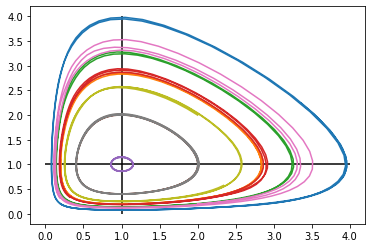

In [10]:
%matplotlib inline

# Exercise 5.6
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def func5_6(t, z, alpha):
    x, y = z
    return np.array([alpha * x - x * y, x * y - y])

def wrap_solve_ivp(alpha, t_span, y0):
    func_aux = (lambda t, x: func5_6(t, x, alpha))
    return solve_ivp(func_aux, t_span=t_span, y0=y0, dense_output=True)

alpha = 1
T = 20

t = np.linspace(0, T, 300)
fig, ax = plt.subplots()
for i in np.linspace(0.2, 2, 3):
    for j in np.linspace(0.2, 2, 3):
        sol = wrap_solve_ivp(alpha, [0, T], [i, j])
        x, y = sol.sol(t)
        ax.plot(x, y)

ax.hlines(y=alpha, xmin=0, xmax=4)
ax.vlines(x=1, ymin=0, ymax=4)
plt.show()


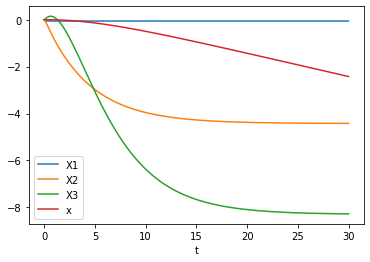

In [11]:
%matplotlib inline

# Exercise 5.7 (a)
import numpy as np
from scipy import optimize
from scipy.integrate import solve_ivp

a = np.array([0.0217, 0.0124, 0.00548])
b = np.array([0.0, 0.0002, 0.0])
g = np.array([1.0, 0.0, 0.0])

A = np.array([[-17.4, 17.4, -9.309], [0, -0.226, 0.879], [0, 0, -0.362]])
B = np.zeros((3, 3))
B[0][2], B[2][2] = 1, 0.00782
C = np.array([[1, -3.42, 4.27], [-0.0943, 1, 0], [0, 0, 1]])

g0, X0, x0 = 0, np.zeros(3), 0

def affsolve_sub(a, A, b, B, C, g, g0, X0, x0):
    n, y0 = len(a), np.append(X0, x0)
    def func_aux(t, z):
        X, x = z[:-1], z[-1]
        CX = np.dot(C.T, X)
        diagCX = np.diag(CX)
        dX = (np.dot(A.T, X) + 0.5 * B.T @ diagCX @ CX - g).reshape(n,)
        dx = np.dot(a, X) + 0.5 * np.dot(b, diagCX @ CX) - g0
        return np.append(dX, dx)

    t_span = np.array([0, 30])
    return solve_ivp(func_aux, t_span=t_span, y0=y0, dense_output=True)

def affsolve(t, a, A, b, B, C, g, g0, X0, x0):
    sol = affsolve_sub(a, A, b, B, C, g, g0, X0, x0)
    return sol.sol(t)

sol = affsolve_sub(a, A, b, B, C, g, g0, X0, x0)
t = np.linspace(0, 30, 300)
plt.plot(t, sol.sol(t).T)
plt.xlabel('t')
plt.legend(['X1', 'X2', 'X3', 'x'], loc=0)
plt.show()

In [12]:
# Exercise 5.7 (b)
def get_stationary_point(A, B, C, g):
    def func_aux(X):
        CX = np.dot(C.T, X)
        diagCX = np.diag(CX)
        dX = np.dot(A.T, X) + 0.5 * B.T @ diagCX @ CX - g
        return float(np.dot(dX, dX))
    
    return optimize.minimize(func_aux, x0=np.zeros(3), method='Nelder-Mead')

stationary_point = get_stationary_point(A, B, C, g)
print(stationary_point.x)

[-0.05747146 -4.42477886 -8.29890491]


In [13]:
# Exercise 5.7 (b): Stand-alone version
def get_stationary_point2(A, B, C, g, tol=1.0e-8, x0=np.zeros(3)):
    def func_aux(X):
        CX = np.dot(C.T, X)
        diagCX = np.diag(CX)
        fval = np.dot(A.T, X) + 0.5 * B.T @ diagCX @ CX - g
        fjac = A.T + 0.5 * B.T @ (2 * diagCX) @ C.T
        return fval, fjac

    X, fval, fjac = x0, *func_aux(x0)
    while any([abs(x) > tol for x in fval]):
        fval, fjac = func_aux(X)
        X = X - np.dot(np.linalg.inv(fjac), fval)
    return X

stationary_point2 = get_stationary_point2(A, B, C, g)
print(stationary_point2)

[-0.05747126 -4.42477876 -8.29891405]


**Exercise 5.8**
First, consider the Taylor series expansion of $x(t + h)$ around $t$:
$$
x (t + h) = x + h f + \frac{h^2}{2} (f_{t} + f_{x} f) + \frac{h^3}{6} \left[f_{tt} + 2 f_{tx} f + f_{xx} f^{2} + f_{x} (f_{t} + f_{x} f) \right] + O \left(h^4 \right)
$$
On the other hand, Runge-Kutta method updates $x_{k}$ by
$$
x_{k+1} = x_{k} + h \left[c_{1} f(t_{k}, x_{k}) + c_{2} f \left(t_{k} + \lambda h, x_{k} + \lambda h f(t_{k}, x_{k}) \right) \right]
$$
Using the Taylor expansion of $f(t + \lambda h, x + \lambda h f)$ around $(t, x)$,
$$
f(t + \lambda h, x + \lambda h f ) = f + \lambda h \left(f_{t} + f_{x} f \right) + \frac{(\lambda h)^2}{2} \left(f_{tt} + 2 f_{tx} + f_{xx} f^{2} \right) + O \left(h^{3} \right)
$$
we observe
$$
x_{k+1} = x_{k} + h c_{1} f + h c_{2} \left[f + \lambda h \left(f_{t} + f_{x} f \right) + \frac{(\lambda h)^2}{2} \left(f_{tt} + 2 f_{tx} + f_{xx} f^{2} \right) \right] + O \left(h^{4} \right)
$$

The truncation error is
$$
\begin{multline}
    x (t + h) - x_{k+1} = h (1- c_{1} - c_{2}) f + h^{2} \left[\left(\frac{1}{2} - \lambda c_{2} \right) f_{t} + \left(\frac{1}{2} - \lambda c_{2} \right) f_{x} f \right] \\
        + \frac{h^{3} (1 - 3 \lambda^{2} c_{2})}{6} \left[ f_{xx} + 2 f_{tx} f + f_{xx} f^{2} \right] + \frac{h^{3}}{6} (f_{t} + f_{x} f) f_{x} + O \left(h^{4} \right)
\end{multline}
$$
The absolute value of the truncation error (up to 3rd order) is minimized when
$$
\begin{aligned}
    &1 - c_{1} - c_{2} = 0 \\
    &\frac{1}{2} - \lambda c_{2} = 0 \\
    &1 - 3 \lambda^{2} c_{2} = 0
\end{aligned}
$$
Hence,
$$
\lambda = \frac{2}{3}, \quad c_{1} = \frac{1}{4}, \quad c_{2} = \frac{3}{4}
$$